## Next Word Prediction

Importing the requeired libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import string

import os

reading the text file

In [2]:
file = open("/content/clean.txt", "r", encoding = "utf8")
lines = []

for i in file:
    lines.append(i)

print("Checking the lines :")
    
print(lines[0])
print(lines[-1])

Checking the lines :
﻿One morning, when Gregor Samsa woke from troubled dreams, he found

first to get up and stretch out her young body.


some preprocessing steps

In [3]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
data[:360]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.  He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections.  The bedding was hardly able to cover it and seemed ready to slide off any moment.'

In [4]:
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
new_data = data.translate(translator)

new_data[:500]

'One morning  when Gregor Samsa woke from troubled dreams  he found himself transformed in his bed into a horrible vermin   He lay on his armour like back  and if he lifted his head a little he could see his brown belly  slightly domed and divided by arches into stiff sections   The bedding was hardly able to cover it and seemed ready to slide off any moment   His many legs  pitifully thin compared with the size of the rest of him  waved about helplessly as he looked    What s happened to me   he'

In [5]:
z = []

for i in data.split():
    if i not in z:
        z.append(i)
        
data = ' '.join(z)
data[:500]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on armour-like back, and if lifted head little could see brown belly, slightly domed divided by arches stiff sections. The bedding was hardly able to cover it seemed ready slide off any moment. His many legs, pitifully thin compared with the size of rest him, waved about helplessly as looked. "What\'s happened me?" thought. It wasn\'t dream. room, proper human room altho'

Tokenization

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:10]

[17, 53, 293, 2, 18, 729, 135, 730, 294, 8]

In [7]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

2617


In [8]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  3889


array([[ 17,  53],
       [ 53, 293],
       [293,   2],
       [  2,  18],
       [ 18, 729],
       [729, 135],
       [135, 730],
       [730, 294],
       [294,   8],
       [  8, 731]])

In [9]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

In [10]:
print("The first words: ", X[:5])
print("The next connect words: ", y[:5])

The first words:  [ 17  53 293   2  18]
The next connect words:  [ 53 293   2  18 729]


In [11]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
vocab_size

2617

Creating Model

In [13]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             26170     
                                                                 
 lstm (LSTM)                 (None, 1, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 2617)              2619617   
                                                                 
Total params: 15,694,787
Trainable params: 15,694,787
Non-trainable params: 0
_________________________________________________________________


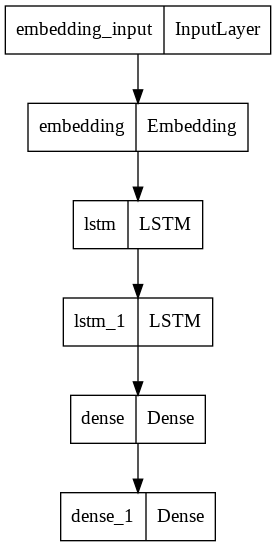

In [15]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001) ,metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
model.fit(X, y, epochs=150, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/150
61/61 [==============================] - ETA: 0s - loss: 7.8754 - accuracy: 0.0013
Epoch 1: loss improved from inf to 7.87541, saving model to nextword1.h5
61/61 [==============================] - 18s 214ms/step - loss: 7.8754 - accuracy: 0.0013 - lr: 0.0010
Epoch 2/150
61/61 [==============================] - ETA: 0s - loss: 7.8616 - accuracy: 0.0026
Epoch 2: loss improved from 7.87541 to 7.86160, saving model to nextword1.h5
61/61 [==============================] - 13s 214ms/step - loss: 7.8616 - accuracy: 0.0026 - lr: 0.0010
Epoch 3/150
61/61 [==============================] - ETA: 0s - loss: 7.8176 - accuracy: 0.0041
Epoch 3: loss improved from 7.86160 to 7.81758, saving model to nextword1.h5
61/61 [==============================] - 13s 214ms/step - loss: 7.8176 - accuracy: 0.0041 - lr: 0.0010
Epoch 4/150
61/61 [==============================] - ETA: 0s - loss: 7.6930 - accuracy: 0.0036
Epoch 4: loss improved from 7.81758 to 7.69302, saving model to nextword1.h5
61/61 [

The Prdiction part will continue on 2.O notebook